Calculating Classification SHAP values...
Plotting 'At-Risk' Drivers (Class 0)...


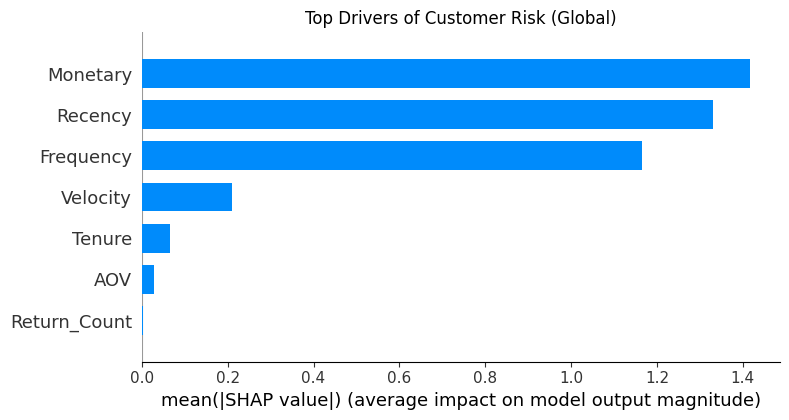

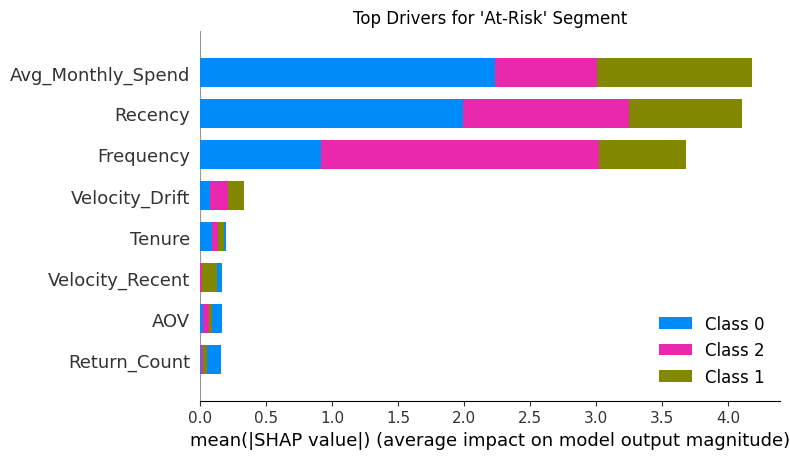

Calculating Spend SHAP values...
Plotting Future Spend Drivers...


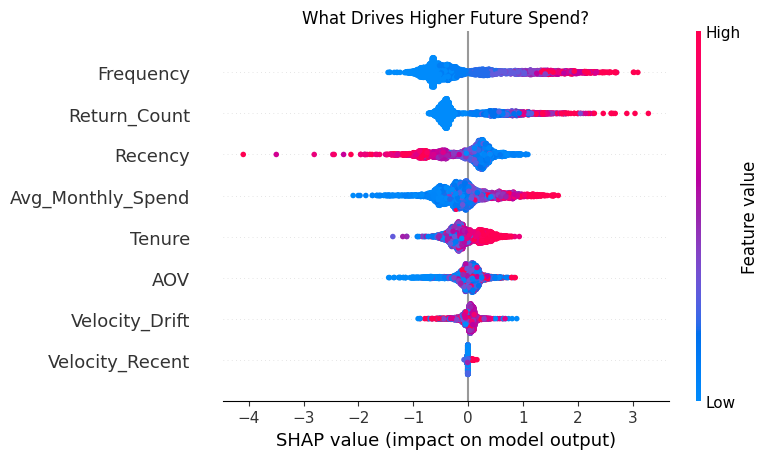

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')

# CONFIGURATION & LOAD

print("Loading data and models...")
DATA_PATH = r'../data/processed/labeled_customers.csv'
MODEL_CLASS_PATH = r'../models/xgb_classifier.json'
MODEL_REG_PATH = r'../models/xgb_regressor.json'

# Load Dataset
try:
    df = pd.read_csv(DATA_PATH)
    if 'Unnamed: 0' in df.columns: df = df.drop(columns=['Unnamed: 0'])
except FileNotFoundError:
    print(f"[ERROR] Data file not found at {DATA_PATH}")
    raise

# Load Models
clf = xgb.XGBClassifier()
clf.load_model(MODEL_CLASS_PATH)

reg = xgb.XGBRegressor()
reg.load_model(MODEL_REG_PATH)

# Feature Consistency Check
features = ['Recency', 'Frequency', 'Avg_Monthly_Spend', 'Tenure', 'AOV', 'Velocity_Recent', 'Velocity_Drift', 'Return_Count']
X = df[features]

print(f"Model loaded. Analyzing {len(X)} records with {len(features)} features.")

# SHAP INITIALIZATION
explainer_clf = shap.TreeExplainer(clf)
explainer_reg = shap.TreeExplainer(reg)

# CLASSIFICATION ANALYSIS (Risk Drivers)
print("\n[INFO] Calculating Classification SHAP values...")
shap_values_clf = explainer_clf.shap_values(X)

# XGBoost returns a list for multi-class; we analyze Class 0 ('At-Risk')
if isinstance(shap_values_clf, list):
    shap_risk = shap_values_clf[0]
else:
    shap_risk = shap_values_clf

# Dimensions check: Ensure SHAP columns match feature columns
if shap_risk.shape[1] > X.shape[1]:
    # Bias term removal if present
    shap_risk = shap_risk[:, :-1]

print("Generating 'At-Risk' Feature Importance Plot...")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_risk, X, plot_type="bar", show=False)
plt.title("Top Drivers for 'At-Risk' Segment")
plt.tight_layout()
plt.show()

# REGRESSION ANALYSIS (Spend Drivers)
print("\n[INFO] Calculating Spend Prediction SHAP values...")
shap_values_reg = explainer_reg.shap_values(X)

# Dimensions check
if shap_values_reg.shape[1] > X.shape[1]:
    shap_values_reg = shap_values_reg[:, :-1]

print("Generating Future Spend Driver Plot...")

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_reg, X, plot_type="dot", show=False)
plt.title("What Drives Higher Future Spend?")
plt.tight_layout()
plt.show()

# LOCAL EXPLANATION (VIP Example)
# Isolate a high-value customer for instance-level debugging
try:
    vip_customer = df[df['Segment_Label'] == 'High Value'].iloc[0]
    vip_idx = df.index[df['CustomerID'] == vip_customer['CustomerID']][0]

    print(f"\n[INFO] Inspecting VIP Customer ID: {vip_customer['CustomerID']}")
    predicted_spend = np.expm1(reg.predict(X.iloc[[vip_idx]]))[0]
    print(f"Predicted 90-Day Spend: ${predicted_spend:.2f}")

    print("Generating Force Plot for VIP instance...")
    shap.force_plot(
        explainer_reg.expected_value, 
        shap_values_reg[vip_idx], 
        X.iloc[vip_idx], 
        matplotlib=True,
        show=False
    )
    plt.title(f"Spend Drivers for Customer {vip_customer['CustomerID']}")
    plt.show()
except IndexError:
    print("[WARN] No High Value customers found to inspect.")